# LSTM for Stock Price Prediction

> Technical Walk-through on LSTM-based Recurrent Neural Network Creation for Google Stock Price Prediction

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [30]:
df = pd.read_csv("data_sets/Google_Stock_Price_Train.csv")
df.replace(',','', regex=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,7380500
1,01/04/2012,331.27,333.87,329.08,666.45,5749400
2,01/05/2012,329.83,330.75,326.89,657.21,6590300
3,01/06/2012,328.34,328.77,323.68,648.24,5405900
4,01/09/2012,322.04,322.29,309.46,620.76,11688800


In [31]:
training_set = df.iloc[:, 4:5].values
training_set

array([['663.59'],
       ['666.45'],
       ['657.21'],
       ...,
       ['1049.369995'],
       ['1048.140015'],
       ['1046.400024']], dtype=object)

## Feature scaling

In [32]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.23757287],
       [0.24151427],
       [0.22878051],
       ...,
       [0.76922122],
       [0.76752617],
       [0.76512827]])

## Data structure creation

A special data structure is needed to cover 60-time stamps, based on which RNN will predict the 61st price. Here the number of past timestamps is set to 60 based on experimentation. Thus, X_train is a nested list, which contains lists of 60 time-stamp prices. y_train is a list of stock prices which is the next day stock price, corresponding to each list in X_train.

In [33]:
X_train = []
y_train = []
steps_size = 60
for i in range(steps_size, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - steps_size: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [34]:
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

## Model building

Note for the LSTM layer, units is the number of LSTM neurons in the layer. 50 neurons will give the model high dimensionality, enough to capture the upwards and downward trends. return_sequences is True as we need to add another LSTM layer after the current one. input_shape corresponds to the number of time stamps and the number of indicators. For dropout, 20% of 50 neurons will be ignored randomly during each iteration of training.

In [35]:
from keras.layers import LSTM, Dropout, Dense
from keras import Sequential

In [36]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(rate = 0.2))
##add 2nd lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))
##add 3rd lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))
##add 4th lstm layer
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.2))

model.add(Dense(units = 1))

In [37]:
model.compile(optimizer ='adam', loss ='mean_squared_error')

## Model fitting

RNN weights are updated every 32 stock prices with a batch size of 32. Feel free to try more batches and epochs if the loss of the model is not converging.

In [38]:
model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 7)
model.save('models/Google_Stock_Price_Prediction_RNN.h5')

Epoch 1/7
46/46 [==============================] - 9s 68ms/step - loss: 0.0282
Epoch 2/7
46/46 [==============================] - 3s 71ms/step - loss: 0.0098
Epoch 3/7
46/46 [==============================] - 3s 68ms/step - loss: 0.0081
Epoch 4/7
46/46 [==============================] - 3s 74ms/step - loss: 0.0072
Epoch 5/7
46/46 [==============================] - 4s 82ms/step - loss: 0.0080
Epoch 6/7
46/46 [==============================] - 3s 74ms/step - loss: 0.0057
Epoch 7/7
46/46 [==============================] - 4s 77ms/step - loss: 0.0052


## Model prediction

In [39]:
dataset_test = pd.read_csv("data_sets/Google_Stock_Price_Test.csv")
real_stock_price = dataset_test.iloc[:, 4:5].values

## Data processing

First, we need to concatenate the train and test datasets for prediction, because we use the previous 60 days’ stock prices to predict the next-day price. In another word, we need the 60 days’ price before the 1st date in the test dataset.

In [42]:
dataset_total = pd.concat((df['Close'], dataset_test['Close']), axis = 0)

Then, create the input for prediction, index starting from the date 60 days before the first date in the test dataset.

In [43]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - steps_size:].values

Third, reshape the inputs to have only 1 column.

In [44]:
inputs = inputs.reshape(-1, 1)

Fourth, using the scale set by the training set, scale the test inputs.

In [45]:
inputs = sc.transform(inputs)

Finally, create the test data structure

In [47]:
X_test = []
for i in range(steps_size, len(inputs)):
    X_test.append(inputs[i - steps_size: i, 0])

X_test = np.array(X_test)
#make numpy array as 3D , adding num of indicator
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], 1))

## Model prediction

In [48]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

predicted_stock_price

4/4 [==============================] - 2s 24ms/step


array([[1081.3904 ],
       [1080.5247 ],
       [1078.9465 ],
       [1077.4595 ],
       [1076.8821 ],
       [1077.7787 ],
       [1080.3175 ],
       [1084.2751 ],
       [1089.2504 ],
       [1095.0139 ],
       [1101.269  ],
       [1107.8248 ],
       [1114.4019 ],
       [1120.7993 ],
       [1127.1044 ],
       [1133.5669 ],
       [1140.1736 ],
       [1146.8365 ],
       [1153.4106 ],
       [1159.6578 ],
       [1165.0836 ],
       [1169.3479 ],
       [1172.1989 ],
       [1172.5552 ],
       [1168.7231 ],
       [1160.2255 ],
       [1146.9194 ],
       [1128.6487 ],
       [1106.6566 ],
       [1082.966  ],
       [1059.6835 ],
       [1038.915  ],
       [1022.5353 ],
       [1011.7833 ],
       [1007.2283 ],
       [1008.8425 ],
       [1015.91345],
       [1027.601  ],
       [1043.0482 ],
       [1060.7705 ],
       [1078.9767 ],
       [1095.4764 ],
       [1108.7308 ],
       [1118.0946 ],
       [1123.6008 ],
       [1125.9292 ],
       [1126.1978 ],
       [1125.

## Result visualization

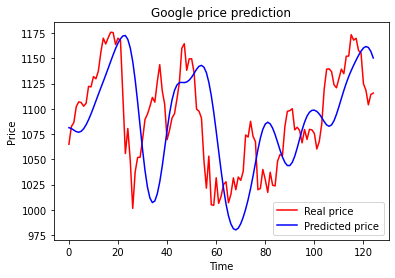

In [49]:
plt.plot(real_stock_price, color = "red", label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')
plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()